<a href="https://colab.research.google.com/github/Geu-Pro2023/Streamlit-ML/blob/main/WildLife_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **WildGuard Conservation Chatbot**

### **Import Libaries**

In [49]:
# Import the essential Libraries
import pandas as pd
import numpy as np
import random
import pickle
import re
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments, pipeline
from datasets import Dataset, load_metric
from sklearn.model_selection import train_test_split
import gradio as gr
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer
import nltk
import json
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [24]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **Loading the Dataset**

In [26]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Wildlife_Chatbot/wildlifebot_dataset.csv')

In [27]:
# Display the first few rows of dataset
df.tail(10)

,Catergory,Question,Answer
4442,eco_friendly_activities,Can gaming help conservation?,Yes! Games like Eco simulate ecosystem balance.
4443,myths_facts,Are hyenas just scavengers?,No! They’re skilled hunters and only scavenge ...
4444,myths_facts,Do koalas get drunk on eucalyptus?,Myth! They’re just sluggish because the leaves...
4445,myths_facts,Can crocodiles cry?,"They “cry” to clean their eyes, not from sadness."
4446,emergencies,Found a baby bird—what do I do?,"Leave it! Parents often nearby. If injured, ca..."
4447,emergencies,How to help oil-covered birds?,Never touch them—call professionals like IFAW ...
4448,emergencies,Snake in my garage!,Stay back and call animal control—most snakes ...
4449,climate_change,How does warming affect monarch butterflies?,It disrupts migration timing and milkweed growth.
4450,climate_change,Are there climate-friendly zoos?,Yes! Many use solar power and recycle water to...
4451,climate_change,Can kelp forests slow climate change?,Yes! They absorb CO2 20x faster than land fore...


## **Data Exploration**

In [29]:
# Load and Explore Data
print("Loading dataset...")

print("\nDataset Overview:")
print(f"Total samples: {len(df)}")
print("\nSample distribution by Catergory:")
print(df['Catergory'].value_counts())

Loading dataset...

Dataset Overview:
Total samples: 4452

Sample distribution by Catergory:
Catergory
volunteering               456
laws_policies              456
habitat_protection         456
greetings                  324
wildlife_threats           276
fun_facts                  276
technology                 276
organizations              276
animal_behavior            276
education                  276
eco_friendly_activities    276
myths_facts                276
emergencies                276
climate_change             276
Name: count, dtype: int64


## **Data Preprocessing**

In [33]:
# Data Preprocessing
print("\nPreprocessing data...")

# Initialize BERT models
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
lemmatizer = WordNetLemmatizer()

# Create intents dictionary
dict_ = {"Catergory": []}
for _, row in df.iterrows():
    dict1 = {
        'tags': [row['Catergory']],
        'patterns': [row['Question'].strip('"')],
        'responses': [row['Answer'].strip('"')]
    }
    dict_['Catergory'].append(dict1)

# Save intents
with open("Wildlifebot_Catergory.json", "w") as f:
    json.dump(dict_, f)

# Initialize processing lists
words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']


Preprocessing data...


## **Feature Extraction using BERT**

In [36]:
# Feature Extraction using BERT

def get_bert_embedding(sentence):
    """Extract BERT embeddings for a given sentence"""
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Process intents
for intent in dict_['Catergory']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

# Lemmatize and sort words
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

# Save preprocessed data
pickle.dump(words, open('wildlife_words.pkl', 'wb'))
pickle.dump(classes, open('wildlife_classes.pkl', 'wb'))

## **Data Preparation**

In [45]:
# Prepare Training Data
print("\nPreparing training data...")
training = []
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    pattern = document[0]
    tag = document[1]
    embedding = get_bert_embedding(pattern)
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

# Split data into features and labels
X = np.array([item[0] for item in training])
y = np.array([item[1] for item in training])

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Preparing training data...


## **Model Architecture**

In [46]:
# Model Architecture
print("\nBuilding model...")
model = Sequential()
model.add(Dense(128, input_shape=(len(X_train[0]),), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(y_train[0]), activation='softmax'))

# Learning rate schedule for better convergence
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Compile model with multiple metrics
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy', 'Precision', 'Recall'])

print("\nModel Summary:")
model.summary()


Building model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,598 (420.30 KB)

 Trainable params: 107,598 (420.30 KB)

 Non-trainable params: 0 (0.00 B)

## **Model Training**

In [47]:
# Model Training
print("\nTraining model...")
history = model.fit(X_train, y_train,
                   epochs=50,
                   batch_size=12,
                   validation_data=(X_val, y_val),
                   verbose=1)


Training model...
Epoch 1/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - Precision: 0.8709 - Recall: 0.3651 - accuracy: 0.5706 - loss: 1.3675 - val_Precision: 0.9960 - val_Recall: 0.9910 - val_accuracy: 0.9938 - val_loss: 0.0631
Epoch 2/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - Precision: 0.9819 - Recall: 0.9636 - accuracy: 0.9720 - loss: 0.1108 - val_Precision: 0.9961 - val_Recall: 0.9961 - val_accuracy: 0.9961 - val_loss: 0.0110
Epoch 3/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - Precision: 0.9899 - Recall: 0.9859 - accuracy: 0.9884 - loss: 0.0473 - val_Precision: 0.9961 - val_Recall: 0.9961 - val_accuracy: 0.9961 - val_loss: 0.0110
Epoch 4/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Precision: 0.9936 - Recall: 0.9919 - accuracy: 0.9928 - loss: 0.0307 - val_Precision: 0.9961 - val_Recall: 0.9961 - val_accuracy: 0.9961 - val_loss: 0.0111
Epoch 5/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - Precision: 0.9942 - Recall: 0.9930 - accuracy: 0.9937 - loss: 0.0255 - val_Precision: 0

## **Model Evaluation**


Evaluating model...


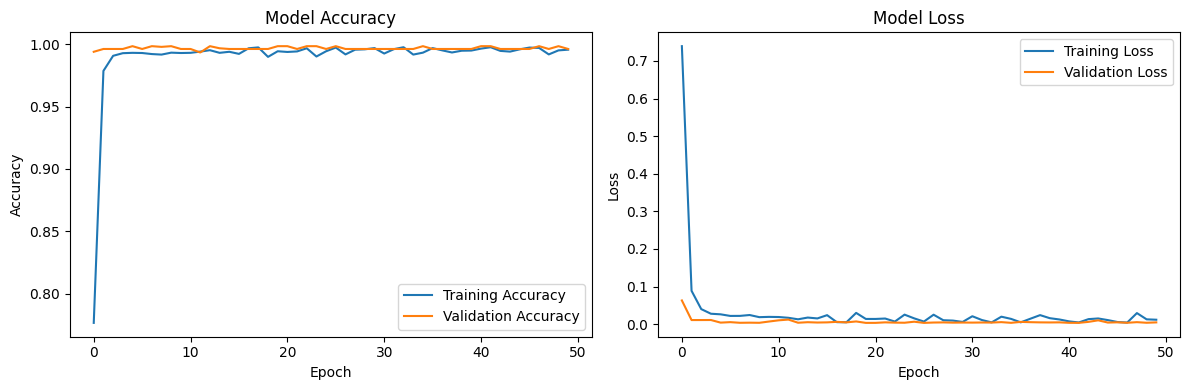

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Validation Metrics:
Accuracy: 0.9961
F1 Score: 0.9960


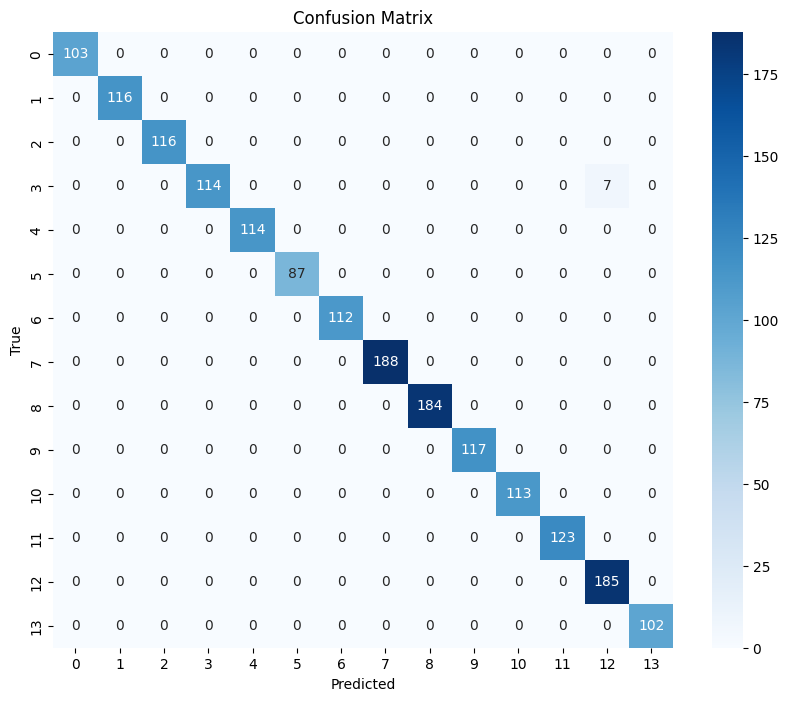

In [50]:
# Model Evaluation

print("\nEvaluating model...")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate validation metrics
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

print("\nValidation Metrics:")
print(f"Accuracy: {accuracy_score(y_val_classes, y_pred_classes):.4f}")
print(f"F1 Score: {f1_score(y_val_classes, y_pred_classes, average='weighted'):.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **Save Model**

In [52]:
# Save Model
model.save('wildlife_chatbot_model.h5')
print("\nModel saved successfully!")


Model saved successfully!


## **Chatbot Interface**

In [53]:
# Chatbot Interface
def predict_class(sentence):
    """Predict the intent class of a given sentence"""
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'Catergory': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    """Get appropriate response based on predicted Catergory"""
    if not intents_list:
        return "I'm not sure how to help with that. Could you rephrase your question?"
    tag = intents_list[0]['Catergory']
    for i in intents_json['Catergory']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "I don't understand. Could you try asking in a different way?"

In [ ]:
# 1. First, let's modify the predict_class function to be more strict
def predict_class(text):
    embedding = get_bert_embedding(text)
    pred = model.predict(embedding)

    # Only consider predictions with >50% confidence
    results = [[i, r] for i, r in enumerate(pred[0]) if r > 0.5]

    if not results:  # If no confident predictions
        return None

    results.sort(key=lambda x: x[1], reverse=True)
    return [{"Catergory": classes[r[0]],
             "probability": str(r[1]),
             "pattern": text} for r in results]

# 2. Enhanced get_response function
def get_response(intents_list, intents_data):
    if not intents_list:
        return "I'm not sure about that wildlife topic. Could you be more specific?"

    best_match = intents_list[0]
    category = best_match['Catergory']
    user_input = best_match['pattern'].lower()

    # Find all possible responses for this category
    possible_responses = []
    for intent in intents_data['Catergory']:
        if category in intent['tags']:
            # Check if user input closely matches any pattern
            for pattern in intent['patterns']:
                if user_input in pattern.lower() or pattern.lower() in user_input:
                    return random.choice(intent['responses'])
            possible_responses.extend(intent['responses'])

    if possible_responses:
        return random.choice(possible_responses)
    return "I don't have information on that specific topic."

# 3. Updated Interactive Testing
print("\n🌿 Wildlife Conservation Expert (type 'quit' to exit)")

while True:
    message = input("\nYou: ").strip()
    if message.lower() in ['quit', 'exit']:
        print("🦉 Thank you for supporting wildlife conservation!")
        break

    ints = predict_class(message)
    response = get_response(ints, dict_)

    print(f"\nBot: {response}")
    if ints:
        print(f"Category: {ints[0]['Catergory']}")
        print(f"Confidence: {float(ints[0]['probability']):.0%}")

    # Show suggestions if confidence is low or no match
    if not ints or float(ints[0]['probability']) < 0.6:
        print("\nTry asking about:")
        print("- Animal habitats ('where do pandas live?')")
        print("- Conservation efforts ('how can I help tigers?')")
        print("- Volunteer opportunities ('can students volunteer?')")


🌿 Wildlife Conservation Expert (type 'quit' to exit)

You: hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Bot: Hello! How can I assist you with wildlife conservation today?
Category: greetings
Confidence: 100%

You: hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Bot: Hi there! How can I support your conservation journey today?
Category: greetings
Confidence: 100%

You: Good morning?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Bot: Good morning! Ready to explore the world of wildlife?
Category: greetings
Confidence: 100%

You: Good evening
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Bot: Good evening! Curious about animals or conservation topics?
Category: greetings
Confidence: 100%

You: Hello bot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Bot: Hi there! How can I support your conservation journey today?
Category: greetings
Confidence: 100%

You: bot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Bot: Hello! I'm  your conservation guide‚ how can I help you?
Category: greetings
Confidence: 100%

You: Good day
1/1 